In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sp
import os as os
import multiprocessing
from joblib import Parallel, delayed
from time import time as ti
from skimage.restoration import denoise_wavelet
import pickle
#import CoreFunctions as cf
import sys
import random
import psutil
import gc

In [2]:
DataFolder = '/sciclone/scr10/dchendrickson01/Recordings2/'
DataFolder = '/scratch/Recordings2/'

DateString = 'Good'
LastGoodModel = 20

TIME_STEPS = 1200
Skips = 600
RollSize = 50

LastSuccesfull = 40

tic = ti()
start = tic

MemoryProtection = False


In [3]:
%matplotlib inline

In [4]:
FilesPerRun = 5
ConcurrentFiles = 5

In [5]:
def RollingStdDevFaster(RawData, SmoothData, RollSize = 25):

    Diffs = RawData - SmoothData
    del RawData, SmoothData
    
    Sqs = Diffs * Diffs
    del Diffs
    
    Sqs = Sqs.tolist() 
    Sqs.extend(np.zeros(RollSize))
    mSqs = np.matrix(Sqs)
    
    for i in range(RollSize):
        Sqs.insert(0, Sqs.pop())
        mSqs = np.concatenate((np.matrix(Sqs),mSqs))
    
    sVect = mSqs.sum(axis=0)
    eVect = (mSqs!=0).sum(axis=0)
    del mSqs, Sqs
    
    VarVect = sVect / eVect
    StdDevs = np.sqrt(VarVect)
    return np.asarray(StdDevs[:-RollSize].T)

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02, verbose = False):
    
    SquelchSignal = np.ones(len(DataSet))
    if verbose:
        print(len(SquelchSignal))
        
    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def split_MorS(original_list, ones_list,MorS,SegIndexes = False):
    # modified split_list_by_ones function to instead split by the zeros.
    #
    #
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, going to use for long lists
    
    result_sublists = []
    SegsEnds = []
    sublist = []
    ii = 0
    
    if MorS == 0:
        for val, is_one in zip(original_list, ones_list):
            if not is_one:
                sublist.append(val)
            elif sublist:
                result_sublists.append(sublist)
                SegsEnds.append(ii)
                sublist = []
            ii+=1
    elif MorS == 1:
        for val, is_one in zip(original_list, ones_list):
            if is_one:
                sublist.append(val)
            elif sublist:
                result_sublists.append(sublist)
                SegsEnds.append(ii)
                sublist = []
            ii+=1
    
    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)
        SegsEnds.append(ii)

    if SegIndexes:
        return result_sublists, SegsEnds
    else:
        return result_sublists

def split_list_by_ones(original_list, ones_list):
    # modified split_list_by_ones function to instead split by the zeros.
    #
    #
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, going to use for long lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS, skips = Skips, IndexEnd = 0):
    output = []
    ends = []
    for i in range(int((len(values) - time_steps + skips)/skips)):
        output.append(values[i*skips : (i*skips + time_steps)])
        ends.append(IndexEnd - len(values) + i*skips + time_steps)
    if IndexEnd ==0:
        return np.stack(output)
    else:
        return np.stack(output), ends

In [6]:
def getVelocity(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    Acceleration -= np.average(Acceleration)
    
    if len(Timestamps) == 1:
        dTime = np.ones(len(Acceleration),dtype=float) * Timestamps
    elif len(Timestamps) == len(Acceleration):
        dTime = np.zeros(len(Timestamps), dtype=float)
        dTime[0]=1
        for i in range(len(Timestamps)-1):
            j = i+1
            if Timestamps[j] > Timestamps[i]:
                dTime[j]=Timestamps[j]-Timestamps[i]
            else:
                dTime[j]=Timestamps[j]-Timestamps[i]+10000.0
        dTime /= 10000.0

    velocity[0] = Acceleration[0] * (dTime[0])

    for i in range(len(Acceleration)-1):
        j = i + 1
        if corrected ==2:
            if Squelch[j]==0:
                velocity[j]=0
            else:
                velocity[j] = velocity[i] + Acceleration[j] * dTime[j]                
        else:
            velocity[j] = velocity[i] + Acceleration[j] * dTime[j]

    if corrected == 1:
        PointVairance = velocity[-1:] / len(velocity)
        for i in range(len(velocity)):
            velocity[i] -=  PointVairance * i
    
    velocity *= 9.81

    return velocity

In [7]:
%matplotlib inline
def runFile(file, verbose = False, small = False, index=0, start=ti()):
    noise = verbose
    dataset = pd.read_csv(DataFolder+file, delimiter =",", header=None, engine='python',on_bad_lines='skip')
    
    
    dataset = dataset.rename(columns={0:"Day"})
    dataset = dataset.rename(columns={1:"Second"})
    dataset = dataset.rename(columns={2:"FracSec"})
    dataset = dataset.rename(columns={3:"p"})
    dataset = dataset.rename(columns={4:"h"})
    dataset = dataset.rename(columns={5:"v"})
    dataset = dataset.rename(columns={6:"Sensor"})
    
    #dataset['Second'].replace('',0)
    #dataset['FracSec'].replace('',0)
    #dataset.replace([np.nan, np.inf, -np.inf],0,inplace=True)
    
    #dataset[['Day','Second']] = dataset[['Day','Second']].apply(lambda x: x.astype(int).astype(str).str.zfill(6))
    #dataset[['FracSec']] = dataset[['FracSec']].apply(lambda x: x.astype(int).astype(str).str.zfill(4))
    
    #dataset["timestamp"] = pd.to_datetime(dataset.Day+dataset.Second+dataset.FracSec,format='%y%m%d%H%M%S%f')
    #dataset["timestamps"] = dataset["timestamp"]
    
    dataset["p"] = dataset.p - np.average(dataset.p)
    dataset["h"] = dataset.h - np.average(dataset.h)
    dataset["v"] = dataset.v - np.average(dataset.v)
    #dataset["r"] = np.sqrt(dataset.p**2 + dataset.h**2 + dataset.v**2)
    
    #dataset.index = dataset.timestamp
    
    dataset["SmoothP"] = denoise_wavelet(dataset.p, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    dataset["SmoothH"] = denoise_wavelet(dataset.h, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    dataset["SmoothV"] = denoise_wavelet(dataset.v, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    #dataset["SmoothR"] = denoise_wavelet(dataset.r, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    
    
    RawData = dataset.v
    SmoothData = dataset.SmoothV
    RollSize = 25
    
    Diffs = RawData - SmoothData
    
    Sqs = Diffs * Diffs
    
    Sqs = Sqs.tolist() 
    
    Sqs.extend(np.zeros(RollSize))
    
    mSqs = np.matrix(Sqs)
    
    for i in range(RollSize):
        Sqs.insert(0, Sqs.pop())
        mSqs = np.concatenate((np.matrix(Sqs),mSqs))
    
    sVect = mSqs.sum(axis=0)
    eVect = (mSqs!=0).sum(axis=0)
    
    VarVect = sVect / eVect
    
    StdDevs = np.sqrt(VarVect)
    
    StdDevsZ = np.asarray(StdDevs)
    
    StdDevsZ=np.append(StdDevsZ,[0])
    
    StdDevsZ = np.asarray(StdDevsZ.T[:len(dataset.p)])
    
    print("Size StdDevsZ", ti()-start, np.shape(StdDevsZ))
    
    StdDevsZ = np.nan_to_num(StdDevsZ)
    
    StdDevsZ[StdDevsZ == np.inf] = 0
    StdDevsZ[StdDevsZ == -np.inf] = 0
    
    SmoothDevZ = denoise_wavelet(StdDevsZ, method='VisuShrink', mode='soft', wavelet='sym2', rescale_sigma='True')
    
    print("denoise 1", ti()-start, np.shape(StdDevsZ))
    
    SmoothDevZ[np.isnan(SmoothDevZ)]=0
    
    Max = np.max(SmoothDevZ)
    
    buckets = int(Max / 0.005) + 1
    bins = np.linspace(0,buckets*0.005,buckets+1)
    counts, bins = np.histogram(SmoothDevZ,bins=bins)
    
    CummCount = 0
    HalfWay = 0
    for i in range(len(counts)):
        CummCount += counts[i]
        if CummCount / len(SmoothDevZ) >= 0.5:
            if HalfWay == 0:
                HalfWay = i
    
    SquelchLevel = bins[HalfWay] 

    fig = plt.figure()
    plt.plot(SmoothDevZ)
    plt.show()    

    if SquelchLevel > .015:
        SL = 0.04
    else:
        SL = 0.02
    
    
    dataset["IsMoving"] = SquelchPattern(SmoothDevZ, 2000, SL, False)
    
    
    velocity = getVelocity(dataset.p, dataset.FracSec, dataset.IsMoving, 2)
    
    df_pr, SegEndr = split_MorS(dataset.p, dataset.IsMoving,1,SegIndexes = True)
    df_hr = split_MorS(dataset.h, dataset.IsMoving,1)
    df_vr = split_MorS(dataset.v, dataset.IsMoving,1)
    
    df_ps, SegEnds = split_MorS(dataset.SmoothP, dataset.IsMoving,0,SegIndexes = True)
    df_hs = split_MorS(dataset.SmoothH, dataset.IsMoving,0)
    df_vs = split_MorS(dataset.SmoothV, dataset.IsMoving,0)
    
    SmoothMove = []
    for i in range(len(df_pr)):
        if len(df_pr[i])>TIME_STEPS:
            tempP,tempE=create_sequences(df_pr[i],IndexEnd=SegEndr[i])
            tempH=create_sequences(df_hr[i])
            tempV=create_sequences(df_vr[i])
            for j in range(len(tempP)):
                SmoothMove.append([np.vstack((tempP[j],tempH[j],tempV[j])),tempE[j],file]) #,df_rs[i])))
    
    SmoothStop = []
    for i in range(len(df_ps)):
        if len(df_ps[i])>TIME_STEPS:
            tempP,tempE=create_sequences(df_ps[i],IndexEnd=SegEnds[i])
            tempH=create_sequences(df_hs[i])
            tempV=create_sequences(df_vs[i])
            for j in range(len(tempP)):
                SmoothStop.append([np.vstack((tempP[j],tempH[j],tempV[j])),tempE[j],file]) #,df_rs[i])))
    
    return SmoothMove, SmoothStop, velocity, SmoothDevZ
    #else:
    #    return ['fail','fail']
        
        #if verbose:
        #    print('Data normalized', ti()-start)

        #return df_p, df_h, df_v, df_r, df_rp, df_rh, df_rv, df_rr


In [8]:
import CoreFunctions as cf

In [9]:
def runWrapper(file_path, verbose=True, small=False, index=0, start=ti()):
    #try:
    rtrn = runFile(file_path, verbose, small, index, start)
    return rtrn
    #except Exception as e:
    #    with open('BadInputs.text', 'a') as bad_file:
    #        bad_file.write(file_path + '\n')
    #    return np.zeros((10, 10, 3))

In [10]:
def PrintWrap(Mat):
    localPrints = []
    lenm = np.shape(Mat)[1]
    slices = int(lenm/TIME_STEPS)
    for i in range(slices):
        temp = (cf.makeMPFast(Mat[:3,i*TIME_STEPS:(i+1)*TIME_STEPS], wvt = 'sym4', scales = 32, spacer = 2, title = ''))
        localPrints.append(temp.astype(np.float32)/255.0)
    return localPrints

# Start Machine Learning
## Using Autoencoder with Kears and Tensorflow
cite: https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/

In [11]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

2024-12-22 08:56:38.302012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-22 08:56:38.677998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-22 08:56:38.773399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 08:56:39.592016: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=24):
        inputShape = (height, width, depth)
        chanDim = -1
        inputs = Input(shape=inputShape)
        x = inputs

        for f in filters:
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        volumeSize = K.int_shape(x)
        print("Volume Size:", volumeSize)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        encoder = Model(inputs, latent, name="encoder")

        latentInputs = Input(shape=(latentDim,))
        flattenedVolumeSize = int(np.prod(volumeSize[1:]))
        print("Flattened Volume Size:", flattenedVolumeSize)
        x = Dense(flattenedVolumeSize)(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)

        decoder = Model(latentInputs, outputs, name="decoder")
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

        return (encoder, decoder, autoencoder)


In [13]:
# set the matplotlib backend so figures can be saved in the background
#import matplotlib
#matplotlib.use("Agg")
# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
# construct the argument parse and parse the arguments

In [14]:
import random
import tensorflow as tf
from tensorflow.keras.models import load_model

In [15]:
tf.config.set_visible_devices([], 'GPU')

In [16]:
from tensorflow.keras.callbacks import Callback

In [17]:
import keras
import re

In [18]:
directory = '/scratch/models/'
target_file = f'3DFP_{DateString}_{str(LastGoodModel).zfill(3)}_good2_ae.keras'

ImageShape=[5,32,600,3]

encoder = load_model(directory+target_file[:-8]+'en.keras')
decoder = load_model(directory+target_file[:-8]+'de.keras')

autoencoder_input = Input(shape=(ImageShape[1], ImageShape[2], ImageShape[3]))

# Pass the input through the encoder and decoder
encoded_repr = encoder(autoencoder_input)
reconstructed = decoder(encoded_repr)

# Create the reassembled autoencoder model
autoencoder = Model(autoencoder_input, reconstructed)

In [19]:
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())
#if LastSuccesfull != 0:
#    print(reautoencoder.summary())

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 600, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 300, 64)    │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 300, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 300, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 150, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 150, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 150, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,228,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,249,472 (4.77 MB)

 Trainable params: 1,249,280 (4.77 MB)

 Non-trainable params: 192 (768.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38400)          │     1,267,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 150, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 300, 32)    │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 300, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 300, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 600, 64)    │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 600, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 600, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 600, 3)     │         1,731 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 600, 3)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,297,059 (4.95 MB)

 Trainable params: 1,296,867 (4.95 MB)

 Non-trainable params: 192 (768.00 B)

None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 600, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │     1,249,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 600, 3)     │     1,297,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,546,531 (9.71 MB)

 Trainable params: 2,546,147 (9.71 MB)

 Non-trainable params: 384 (1.50 KB)

None


In [20]:
def getTensors(file_list):

    AllDatas = Parallel(n_jobs=ConcurrentFiles)(delayed(runFile)(file_list[i], False, False, 0, ti()) for i in range(min(len(file_list),FilesPerRun)))

    Moves=[]
    StopIndex=[]
    Stops=[]
    MoveIndex=[]
    StopFiles=[]
    MoveFiles=[]

    for fileResponse in AllDatas:
        for Mat in fileResponse[0]:
            Moves.append(Mat[0])
            MoveIndex.append(Mat[1])
            MoveFiles.append(Mat[2])
        for Mat in fileResponse[1]:
            Stops.append(Mat[0])
            StopIndex.append(Mat[1])
            StopFiles.append(Mat[2])
        #fig = plt.figure()
        #plt.plot(fileResponse[3])
        #plt.show()
        #fig = plt.figure()
        #plt.plot(fileResponse[2])
        #plt.show()
        
            
    if MemoryProtection:
        del AllDatas
        print('RAM after AllData:', psutil.virtual_memory()[2], len(Mats))        

    MovePrints = Parallel(n_jobs=8)(delayed(PrintWrap)(Mat) for Mat in Moves)
    StopPrints = Parallel(n_jobs=8)(delayed(PrintWrap)(Mat) for Mat in Stops)
    
    if MemoryProtection:
        del Mats, Runs
        print('RAM after Keeps:', psutil.virtual_memory()[2])
    
    mPrint = []
    sPrint = []    
    for group in MovePrints:
        for fprint in group:
            mPrint.append(fprint[:, ::2, :])
    for group in StopPrints:
        for fprint in group:
            sPrint.append(fprint[:, ::2, :])
    
    if MemoryProtection:
        del MovePrints, StopPrints
    
    for i, image in enumerate(mPrint):
        if not isinstance(image, np.ndarray):
            Prints[i] = np.array(image, dtype=np.float32)
        elif image.dtype != np.float32:
            Prints[i] = image.astype(np.float32)
    for i, image in enumerate(sPrint):
        if not isinstance(image, np.ndarray):
            Rprint[i] = np.array(image, dtype=np.float32)
        elif image.dtype != np.float32:
            Rprint[i] = image.astype(np.float32)
    
    # Stack the images into a single NumPy array
    move_array = np.stack(mPrint, axis=0)
    stop_array = np.stack(sPrint, axis=0)
    
    if MemoryProtection:
        del Prints, Rprint
        print('RAM after Prints:', psutil.virtual_memory()[2])
    # Convert the NumPy array to a TensorFlow tensor
    MoveTensor = tf.convert_to_tensor(move_array)
    StopTensor = tf.convert_to_tensor(stop_array)
    
    if MemoryProtection:
        del prints_array, rprint_array
    return MoveTensor, StopTensor, fileResponse[3], fileResponse[2], MoveIndex, StopIndex, MoveFiles, StopFiles, Moves, Stops

In [21]:
files=['230801 recording1.csv',
       '230802 recording1.csv',
       '230424 recording3.csv',
       '230627 recording1.csv',
       '230629 recording1.csv',
       '230426 recording3.csv',
       '230104 recording3.csv',
       '230106 recording3.csv'
       '230823 recording2.csv',
       '230825 recording2.csv',
       '230119 recording1.csv'
       ]


In [22]:
%%time
Moves, Stops, StdDev, Velocity, MoveLoc, StopLoc, MoveFiles, StopFiles, MoveData, StopData = getTensors(files)

Size StdDevsZ 57.9648814201355 (5419647,)
denoise 1 58.30938124656677 (5419647,)
Figure(640x480)
Size StdDevsZ 203.18531394004822 (19249926,)
denoise 1 204.42065358161926 (19249926,)
Figure(640x480)
Size StdDevsZ 202.10011911392212 (18724440,)
denoise 1 203.36372542381287 (18724440,)
Figure(640x480)
Size StdDevsZ 205.25196862220764 (19255598,)
denoise 1 206.52984070777893 (19255598,)
Figure(640x480)
Size StdDevsZ 204.57011890411377 (18869829,)
denoise 1 205.82568860054016 (18869829,)
Figure(640x480)
CPU times: user 2min 8s, sys: 2min 49s, total: 4min 58s
Wall time: 19min 10s


2024-12-22 09:15:57.850301: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27896601600 exceeds 10% of free system memory.


In [23]:
len(Moves)

10936

In [24]:
len(Stops)

121079

In [25]:
print(f'{np.shape(Moves)}, {np.shape(Stops)}, \n {np.shape(StdDev)}, {np.shape(Velocity)}, \n {np.shape(MoveLoc)}, {np.shape(StopLoc)}, \n {np.shape(MoveFiles)}, {np.shape(StopFiles)}, \n {np.shape(MoveData)}, {np.shape(StopData)}')

(10936, 32, 600, 3), (121079, 32, 600, 3), 
 (19249926,), (19249926,), 
 (10936,), (121079,), 
 (10936,), (121079,), 
 (10936, 3, 1200), (121079, 3, 1200)


In [26]:
MovePred = autoencoder.predict(Moves)
StopPred = autoencoder.predict(Stops)

I0000 00:00:1734876979.369890 3763616 service.cc:146] XLA service 0x14ef3400c110 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734876979.369935 3763616 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-12-22 09:16:19.621828: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734876980.595185 3763616 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


342/342 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step
3784/3784 ━━━━━━━━━━━━━━━━━━━━ 349s 92ms/step


2024-12-22 09:22:44.766221: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27896601600 exceeds 10% of free system memory.


In [27]:
Diff_Move = Moves-MovePred
Diff_Stop = Stops-StopPred

2024-12-22 09:23:00.971618: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27896601600 exceeds 10% of free system memory.
2024-12-22 09:23:18.200679: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27896601600 exceeds 10% of free system memory.


In [28]:
MSE_Move_Pixel = np.mean(Diff_Move**2,axis=3)
MSE_Stop_Pixel = np.mean(Diff_Stop**2,axis=3)

2024-12-22 09:23:27.004219: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27896601600 exceeds 10% of free system memory.


In [29]:
MSE_Move_Time = np.mean(MSE_Move_Pixel,axis=1)

In [30]:
MSE_Stop_Time = np.mean(MSE_Stop_Pixel,axis=1)

In [31]:
MSE_Move_Frame = np.mean(MSE_Move_Time,axis=1)
MSE_Stop_Frame = np.mean(MSE_Stop_Time,axis=1)
print('RAM after Predictions and Deltas:', psutil.virtual_memory()[2])

RAM after Predictions and Deltas: 72.7


In [32]:
MoveResult = np.mean(MSE_Move_Frame)
StopResult = np.mean(MSE_Stop_Frame)

In [33]:
RResultsS = []
RResultsA = []
RResultsM = []
RResultsAM = []
RResultsMS = []
RResultsSS = []
for result in Diff_Move:
    RResultsS.append(np.sum(result))
    RResultsA.append(np.sum(np.abs(result)))
    RResultsM.append(np.mean(result))
    RResultsAM.append(np.mean(np.abs(result)))
    RResultsMS.append(np.mean(result**2))
    RResultsSS.append(np.sum(result**2))

In [34]:
SResultsS = []
SResultsA = []
SResultsM = []
SResultsAM = []
SResultsMS = []
SResultsSS = []
for result in Diff_Stop:
    SResultsS.append(np.sum(result))
    SResultsA.append(np.sum(np.abs(result)))
    SResultsM.append(np.mean(result))
    SResultsAM.append(np.mean(np.abs(result)))
    SResultsMS.append(np.mean(result**2))
    SResultsSS.append(np.sum(result**2))
    

In [35]:
StopSortIndexes=np.argsort(SResultsMS)

StopData = np.array(StopData)
StopSortIndexes = np.array(StopSortIndexes, dtype=np.int64)
StopTimeErrSorted = np.asarray(MSE_Stop_Time)
StopFilesSorted = np.asarray(StopFiles)
StopIndexesSorted = np.asarray(StopLoc)

StopDataSorted=StopData[StopSortIndexes]
StopPredSorted=StopPred[StopSortIndexes]
StopTimeErrSorted = MSE_Stop_Time[StopSortIndexes]
StopFilesSorted = StopFilesSorted[StopSortIndexes]
StopIndexesSorted = StopIndexesSorted[StopSortIndexes]
StopImgSorted = [Stops[i] for i in StopSortIndexes]
StopErrSorted = [Diff_Stop[i] for i in StopSortIndexes]

In [36]:
MoveSortIndexes=np.argsort(RResultsMS)

MoveData = np.array(MoveData)
MoveTimeErrSorted = np.asarray(MSE_Move_Time)
MoveSortIndexes = np.asarray(MoveSortIndexes, dtype=np.int64)
MoveFilesSorted = np.asarray(MoveFiles)
MoveIndexesSorted = np.asarray(MoveLoc)

MoveDataSorted=MoveData[MoveSortIndexes]
MovePredSorted=MovePred[MoveSortIndexes]
MoveTimeErrSorted = MSE_Move_Time[MoveSortIndexes]
MoveFileSorted = [StopSortIndexes]
MoveImgSorted = [Moves[i] for i in MoveSortIndexes]
MoveErrSorted = [Diff_Move[i] for i in MoveSortIndexes]

In [43]:
del MoveData, Moves, Diff_Move, MovePred, MoveFiles, MoveLoc
del StopData, Stops, Diff_Stop, StopPred, StopFiles, StopLoc

In [37]:
import matplotlib.gridspec as gridspec

In [62]:
def QuadPlot(Data, FP, Err, Pred, file='', tic=''):
    # Create a figure
    fig = plt.figure(dpi=300)
    
    # Create a GridSpec with 2 rows and 2 columns, and different width ratios for columns
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])  # Adjust width_ratios as needed
    
    # First row, first column (smaller)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(Data[0,:],linewidth=0.5,color='r')
    ax1.plot(Data[1,:],linewidth=0.5, color='lime')
    ax1.plot(Data[2,:],linewidth=0.5,color='b')
    if file != '' and tic != '':
        ax1.set_title(f'Recorded Signal, {file} at {tic}')
    else:
        ax1.set_title(f'Recorded Signal')
    
    # First row, second column (larger)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(np.abs(FP), origin='lower',aspect='auto')
    ax2.axis("off")
    ax2.set_title('3D Fingerprint')

    TEC0 = np.sum(Err[:,:,0],axis=0)
    TEC1 = np.sum(Err[:,:,1],axis=0)
    TEC2 = np.sum(Err[:,:,2],axis=0)
    
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(np.sum(np.sum(Err,axis=2),axis=0),linewidth=0.8,color='black')
    ax3.plot(TEC0,linewidth=0.5,color='r')
    ax3.plot(TEC1,linewidth=0.5,color='lime')
    ax3.plot(TEC2,linewidth=0.5,color='b')
    SumErr = np.sum(np.sum(np.sum(Err,axis=2),axis=0))
    ax3.set_title(rf'Sum Error over Time, $\Sigma$ = {np.sum(Err):.2f}')

    # Second row, second column (larger)
    combined_data = np.concatenate((TEC0,TEC1,TEC2))
    bins = np.histogram_bin_edges(combined_data, bins=30)
    
    hist1, bins = np.histogram(TEC0, bins=bins)
    hist2, _ = np.histogram(TEC1, bins=bins)
    hist3, _ = np.histogram(TEC2, bins=bins)
    
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.hist([TEC0, TEC1, TEC2],bins=bins,color=['r','lime','b'],stacked=True)
    #ax4.bar(bins[:-1], hist1, width=np.diff(bins), color='r')
    #ax4.bar(bins[:-1], hist2, width=np.diff(bins), bottom=hist1, color='lime')
    #ax4.bar(bins[:-1], hist3, width=np.diff(bins), bottom=hist2, color='b')
    plt.tight_layout()

       
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


In [39]:
from matplotlib.colors import LinearSegmentedColormap

# Define the custom colormap
colors = [(0, 0, 0), (0, 1, 0)]  # Black to Lime
n_bins = 100  # Number of bins in the colormap
cmap_name = 'black_lime'
lime_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

colors = [(0, 0, 0), (1, 0, 0)]  # Black to Lime
n_bins = 100  # Number of bins in the colormap
cmap_name = 'black_red'
red_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

colors = [(0, 0, 0), (0, 0, 1)]  # Black to Lime
n_bins = 100  # Number of bins in the colormap
cmap_name = 'black_blue'
blue_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


In [40]:
def bigChart(Data, FP, Err, Pred, file='', tic=''):

    gs = gridspec.GridSpec(7, 1)  # Adjust width_ratios as needed

    fig = plt.figure(figsize=(8,11),dpi=300)
    
    axs0 = fig.add_subplot(gs[0, 0])
    axs0.plot(Data[0,:],linewidth=0.5,color='r')
    axs0.plot(Data[1,:],linewidth=0.5, color='lime')
    axs0.plot(Data[2,:],linewidth=0.5,color='b')
    plt.xlim([0,1200])
    ticks = np.linspace(0, 1200, 7) 
    labels = np.linspace(0, 600, 7) 
    plt.xticks(ticks, labels)

    FpShape = np.shape(FP[:,:,0])
    Al,Ms  = np.meshgrid(np.arange(0,FpShape[1]),np.arange(0,FpShape[0]))
    
    axs1 = fig.add_subplot(gs[1, 0])
    axs1.contourf(Al,Ms, FP[:,:,0],cmap=red_cmap,levels=12)
    axs1.axis("off")

    axs2 = fig.add_subplot(gs[2, 0])
    axs2.contourf(Al,Ms, FP[:,:,1],cmap=lime_cmap,levels=12)
    axs2.axis("off")
    
    axs3 = fig.add_subplot(gs[3, 0])
    axs3.contourf(Al,Ms, FP[:,:,2],cmap=blue_cmap,levels=12)
    axs3.axis("off")

    axs4 = fig.add_subplot(gs[4, 0])
    axs4.imshow(np.abs(FP), origin='lower',aspect='auto')
    axs4.axis("off")
    axs4.set_title('3D Fingerprint')

    axs5 = fig.add_subplot(gs[5, 0])
    if np.shape(Err)[0]==600:
        axs5.plot(Err)  # Example plot
        SumErr = np.sum(Err)
        axs5.set_title(rf'MSE over Time, $\Sigma$ = {np.sum(Err):.2f}')
    else:
        axs5.plot(np.sum(np.sum(Err,axis=2),axis=0),linewidth=0.8,color='black')
        axs5.plot(np.sum(Err[:,:,0],axis=0),linewidth=0.5,color='r')
        axs5.plot(np.sum(Err[:,:,1],axis=0),linewidth=0.5,color='lime')
        axs5.plot(np.sum(Err[:,:,2],axis=0),linewidth=0.5,color='b')
        SumErr = np.sum(np.sum(np.sum(Err,axis=2),axis=0))
        axs5.set_title(rf'Sum Error over Time, $\Sigma$ = {np.sum(Err):.2f}')
    plt.xlim([0,600])
    ticks = np.linspace(0, 600, 7) 
    labels = np.linspace(0, 600, 7) 
    plt.xticks(ticks, labels)
    
    axs6 = fig.add_subplot(gs[6, 0])
    axs6.imshow(np.abs(Pred), origin='lower',aspect='auto')
    axs6.axis("off")
    axs6.set_title('Autoencoder Reconstruction')



In [45]:
def TDFPBuildChart(Data, FP, Err, Pred, file='', tic=''):

    gs = gridspec.GridSpec(5, 1)  # Adjust width_ratios as needed

    fig = plt.figure(figsize=(8,11),dpi=300)
    
    axs0 = fig.add_subplot(gs[0, 0])
    axs0.plot(Data[0,:],linewidth=0.5,color='r')
    axs0.plot(Data[1,:],linewidth=0.5, color='lime')
    axs0.plot(Data[2,:],linewidth=0.5,color='b')
    plt.xlim([0,1200])
    ticks = np.linspace(0, 1200, 7) 
    labels = np.linspace(0, 600, 7) 
    plt.xticks(ticks, labels)

    FpShape = np.shape(FP[:,:,0])
    Al,Ms  = np.meshgrid(np.arange(0,FpShape[1]),np.arange(0,FpShape[0]))
    
    axs1 = fig.add_subplot(gs[1, 0])
    axs1.contourf(Al,Ms, FP[:,:,0],cmap=red_cmap,levels=12)
    axs1.axis("off")

    axs2 = fig.add_subplot(gs[2, 0])
    axs2.contourf(Al,Ms, FP[:,:,1],cmap=lime_cmap,levels=12)
    axs2.axis("off")
    
    axs3 = fig.add_subplot(gs[3, 0])
    axs3.contourf(Al,Ms, FP[:,:,2],cmap=blue_cmap,levels=12)
    axs3.axis("off")

    axs4 = fig.add_subplot(gs[4, 0])
    axs4.imshow(np.abs(FP), origin='lower',aspect='auto')
    axs4.axis("off")
    axs4.set_title('3D Fingerprint')

In [41]:
asdfasdf

NameError: name 'asdfasdf' is not defined

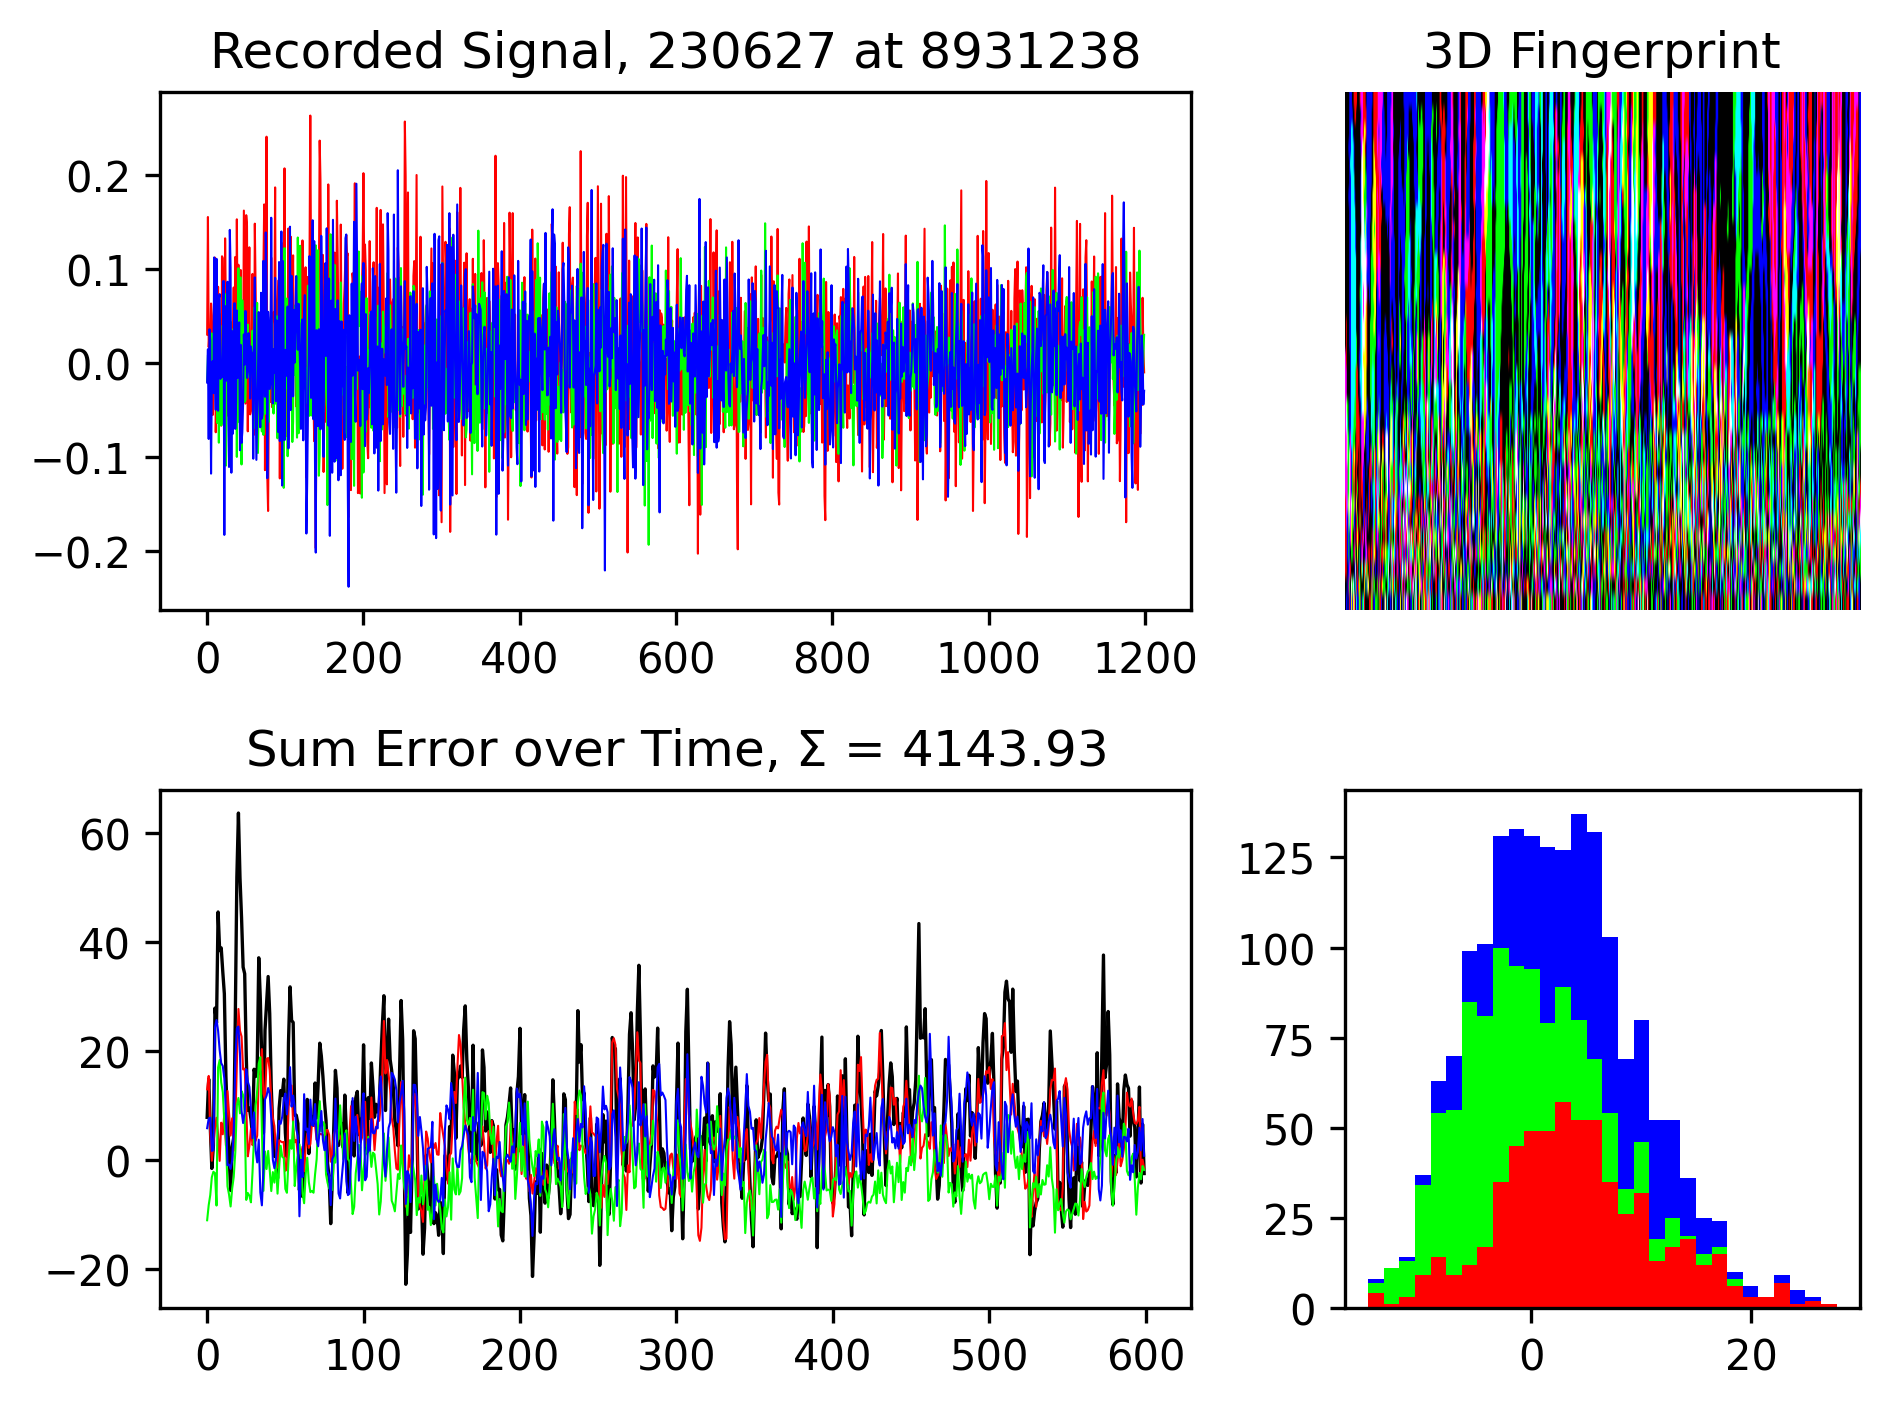

In [79]:
i = np.unravel_index(np.argmax(MoveTimeErrSorted),MoveTimeErrSorted.shape)[0]
QuadPlot(MoveDataSorted[i], MoveImgSorted[i], MoveErrSorted[i], MovePredSorted[i], MoveFilesSorted[i][:6], MoveIndexesSorted[i])

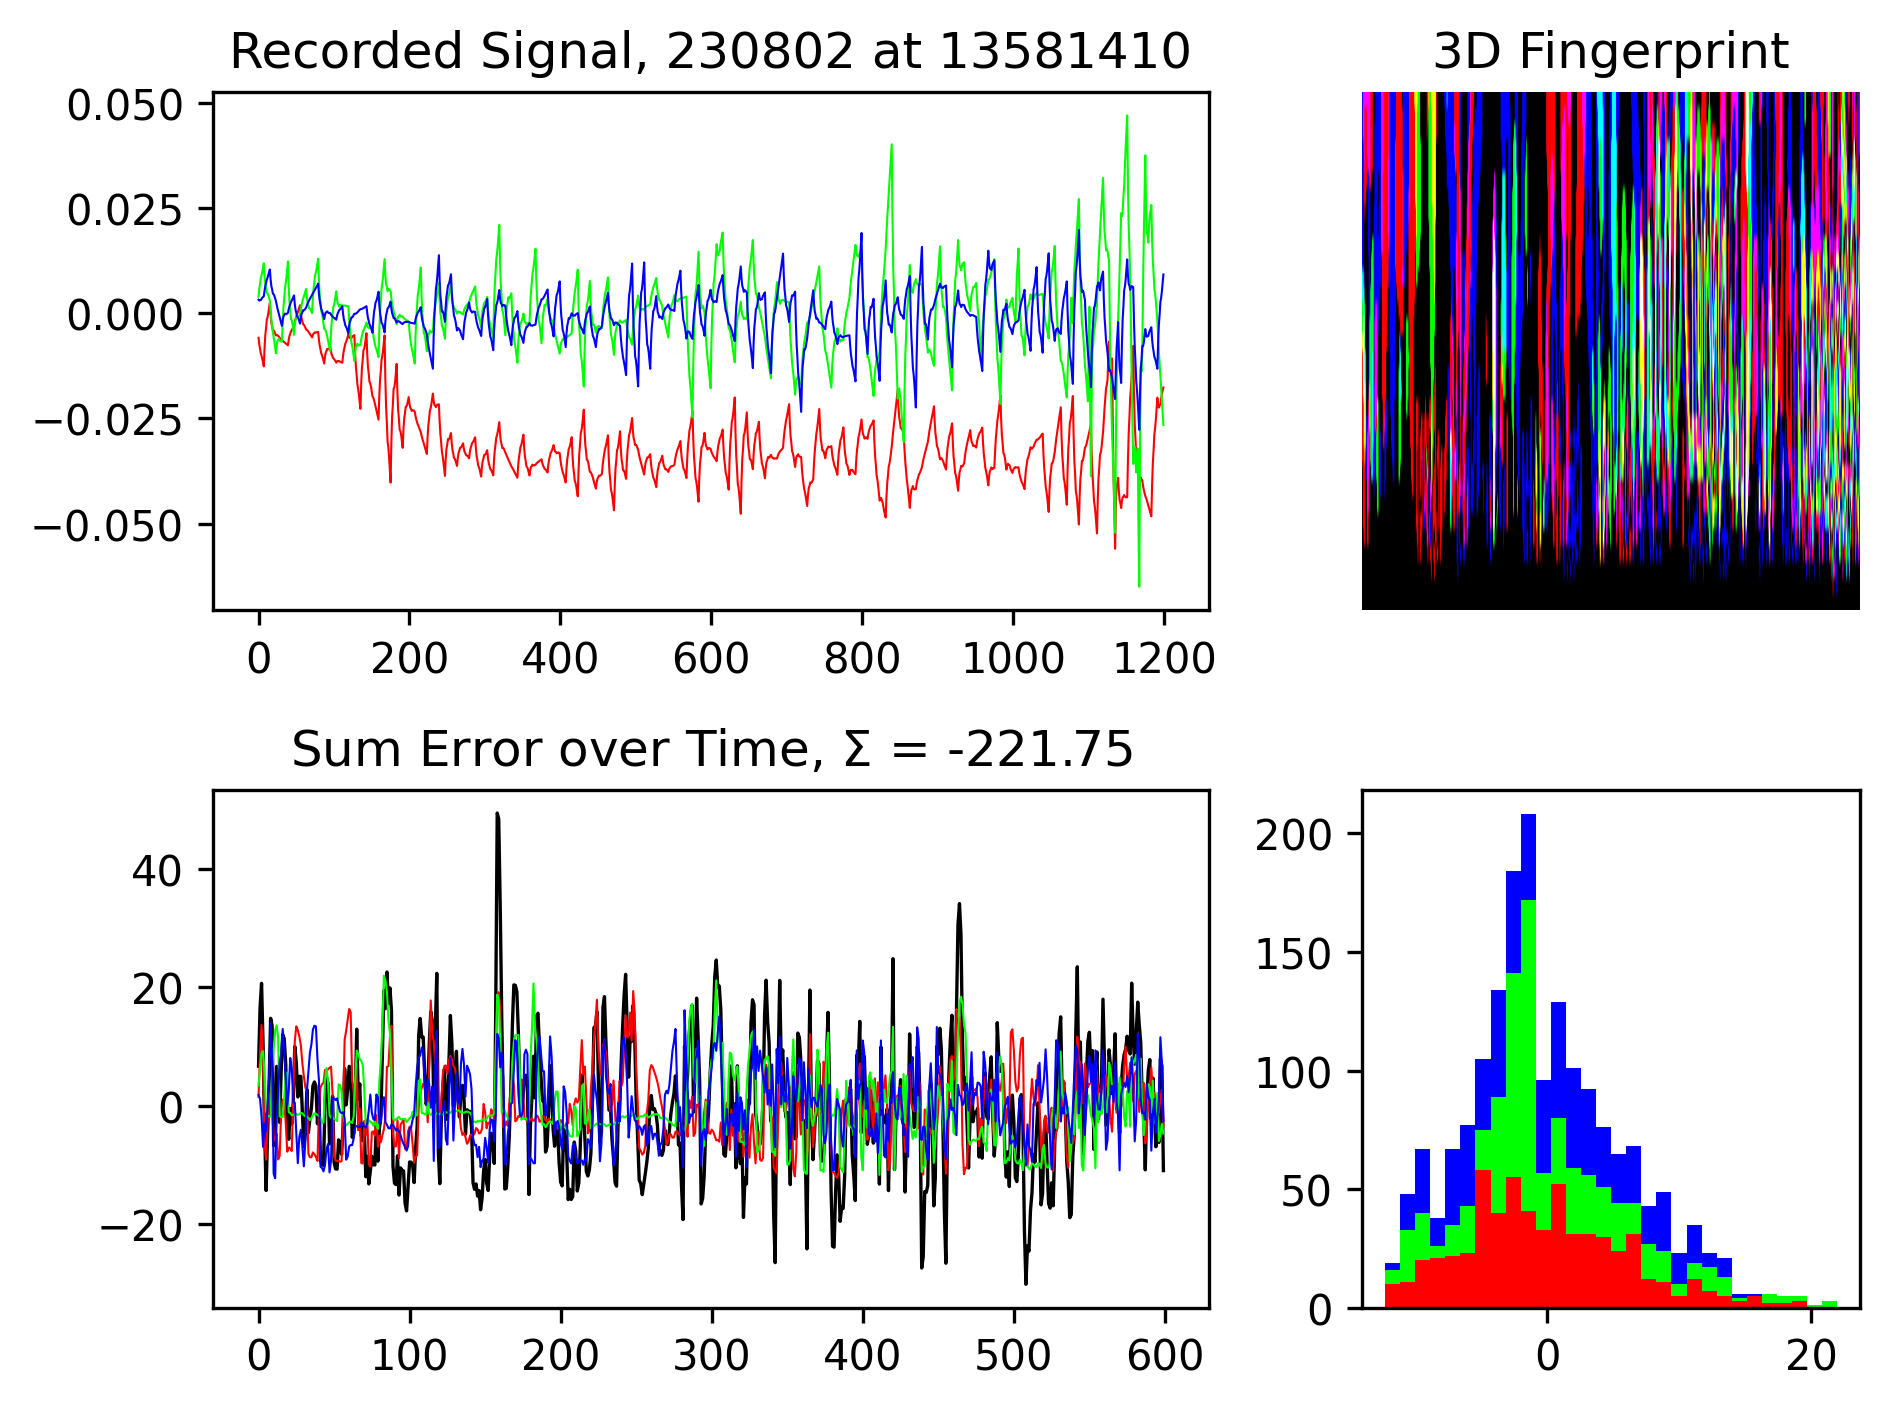

In [75]:
i = np.unravel_index(np.argmax(StopTimeErrSorted),StopTimeErrSorted.shape)[0]
QuadPlot(StopDataSorted[i], StopImgSorted[i], StopErrSorted[i], StopPredSorted[i], StopFilesSorted[i][:6], StopIndexesSorted[i])

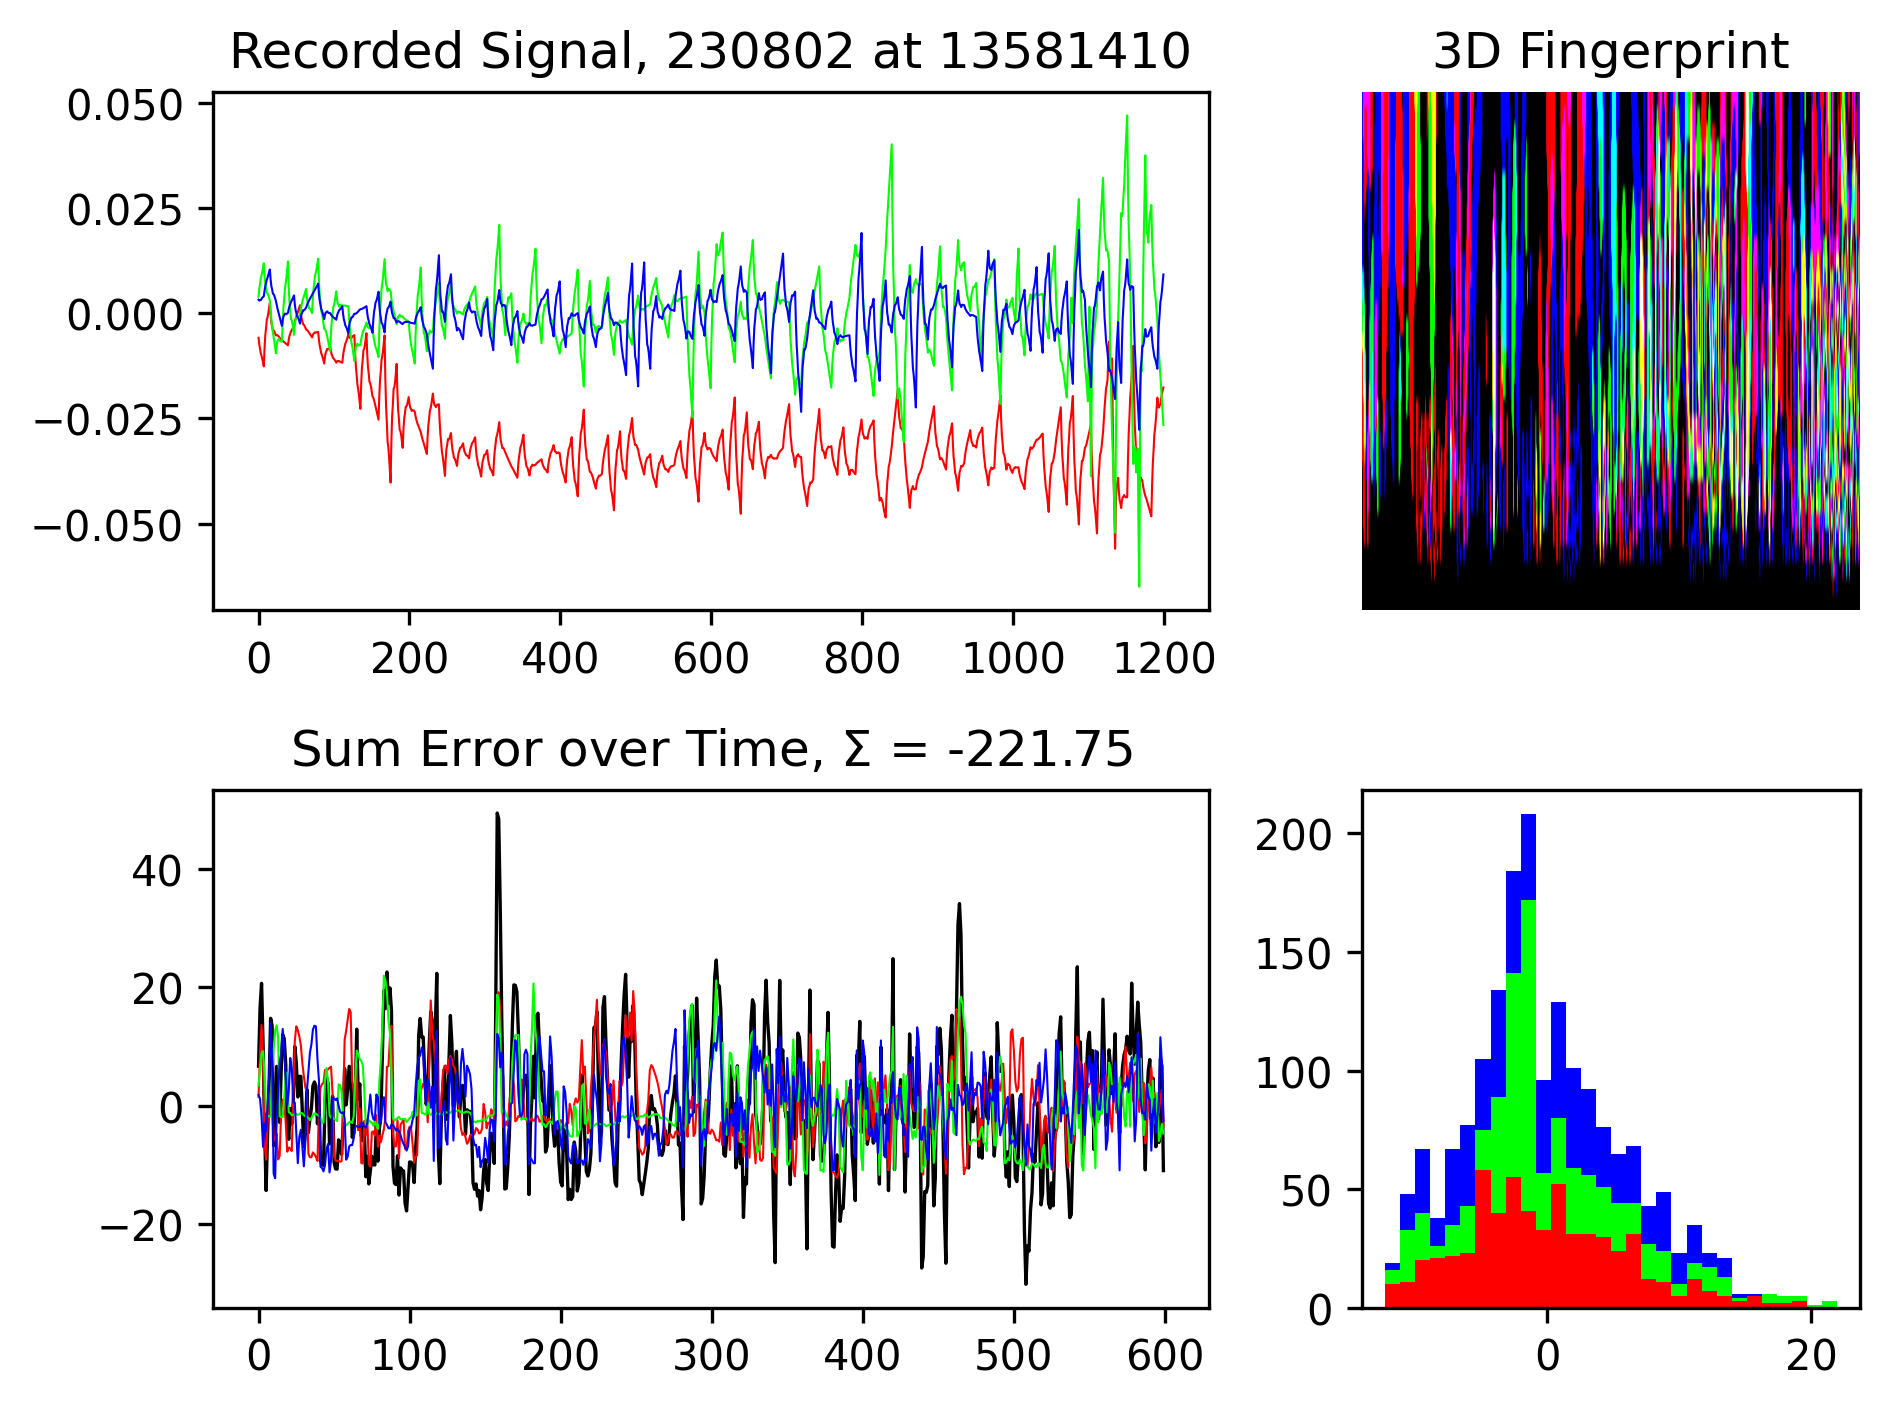

In [73]:
i = np.unravel_index(np.argmax(StopTimeErrSorted),StopTimeErrSorted.shape)[0]
QuadPlot(StopDataSorted[i], StopImgSorted[i], StopErrSorted[i], StopPredSorted[i], StopFilesSorted[i][:6], StopIndexesSorted[i])

In [ ]:
i = np.unravel_index(np.argmax(np.abs(StopErrSorted)),StopTimeErrSorted.shape)[0]
QuadPlot(StopDataSorted[i], StopImgSorted[i], StopErrSorted[i], StopPredSorted[i], StopFilesSorted[i][:6], StopIndexesSorted[i])

In [72]:
len(MoveErrSorted)

10936

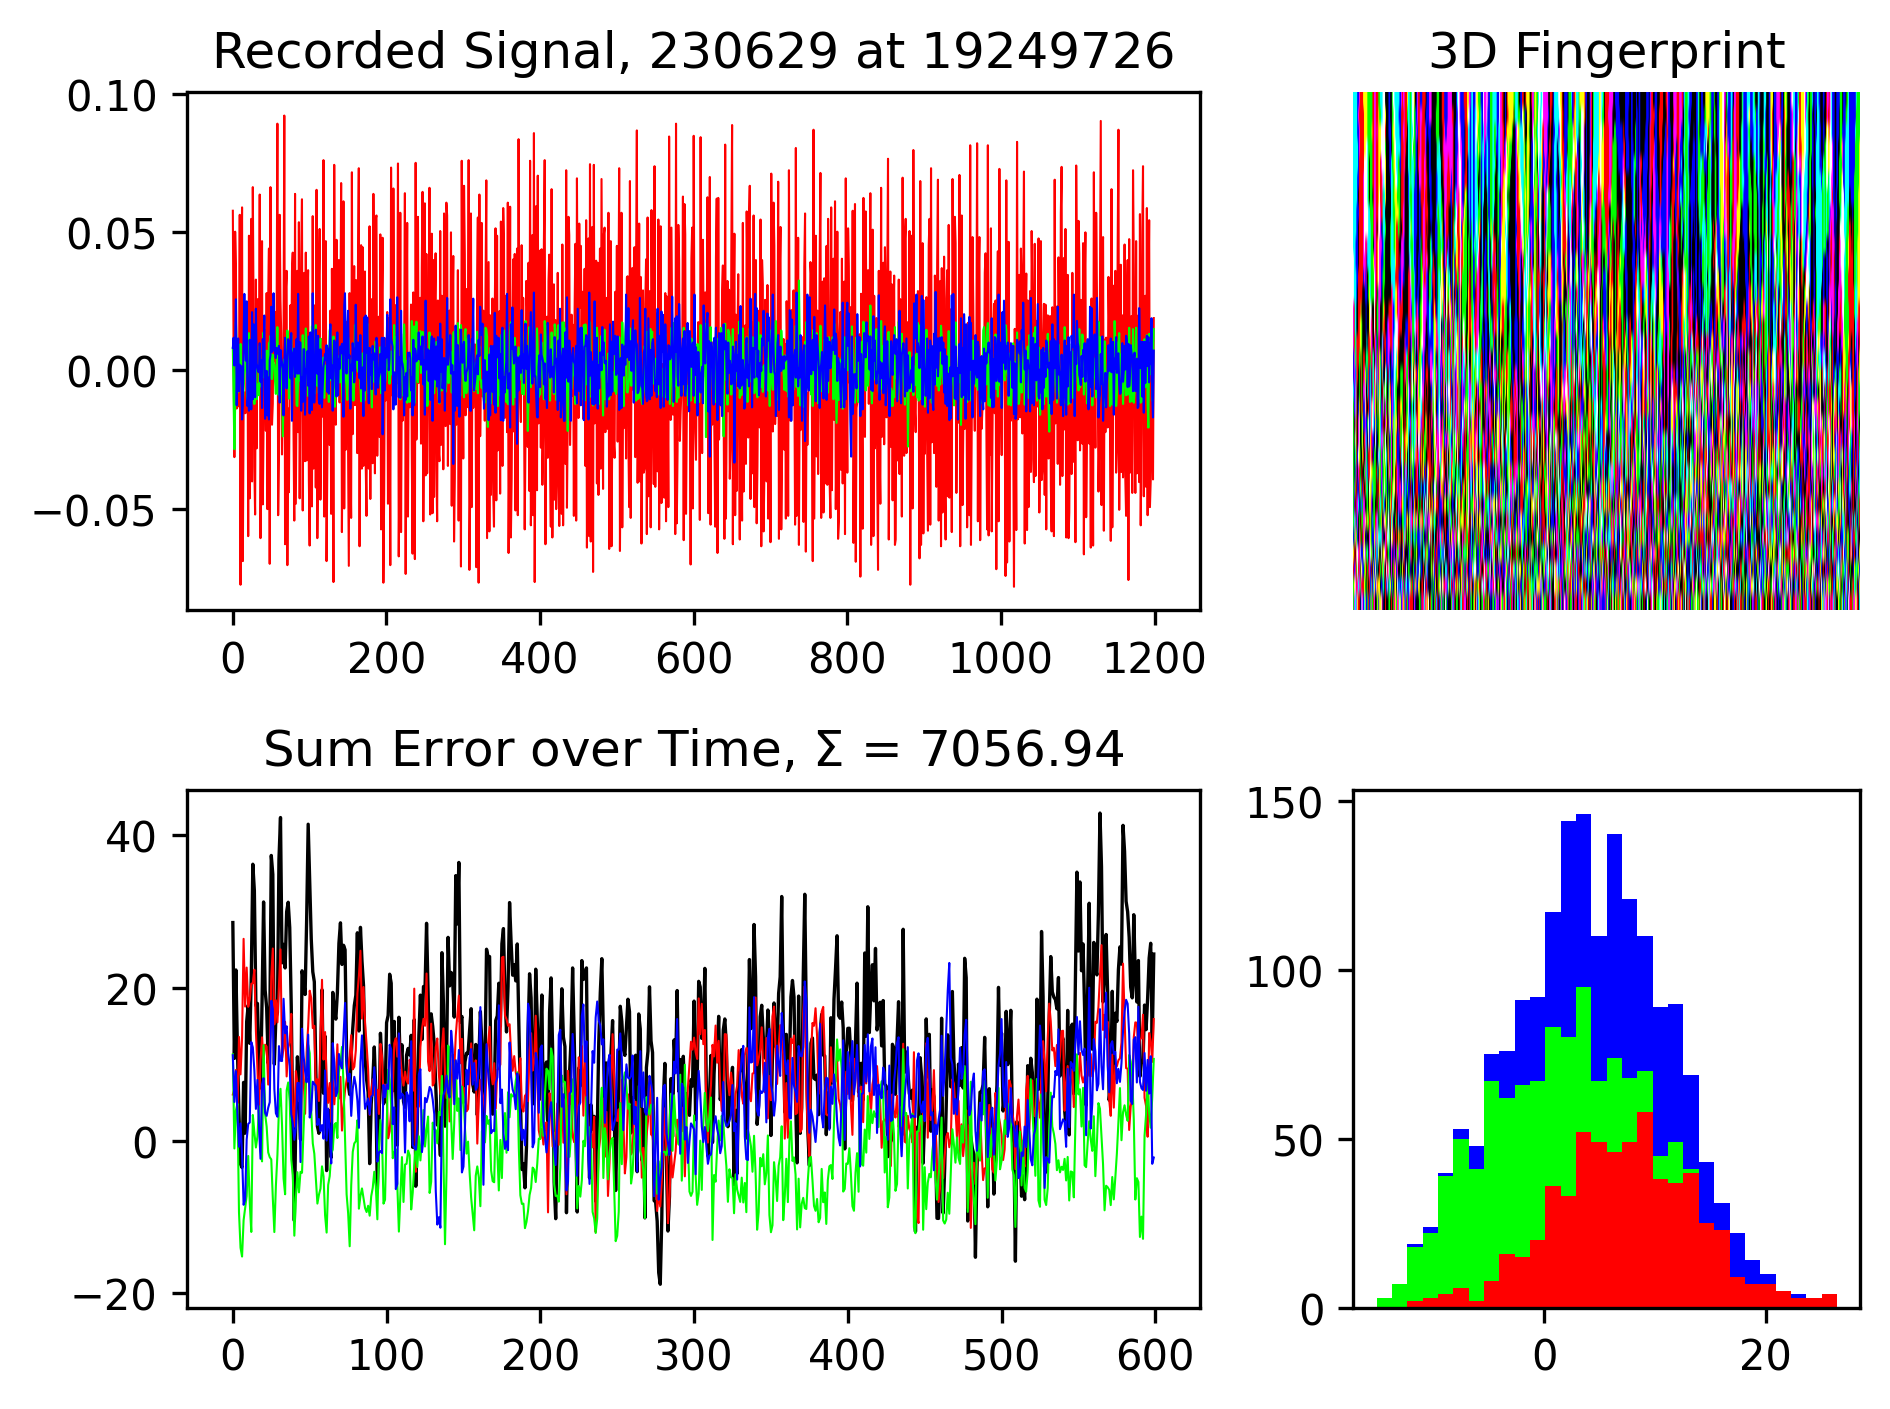

In [66]:
i=10935
QuadPlot(MoveDataSorted[i], MoveImgSorted[i], MoveErrSorted[i], MovePredSorted[i], MoveFilesSorted[i][:6], MoveIndexesSorted[i])

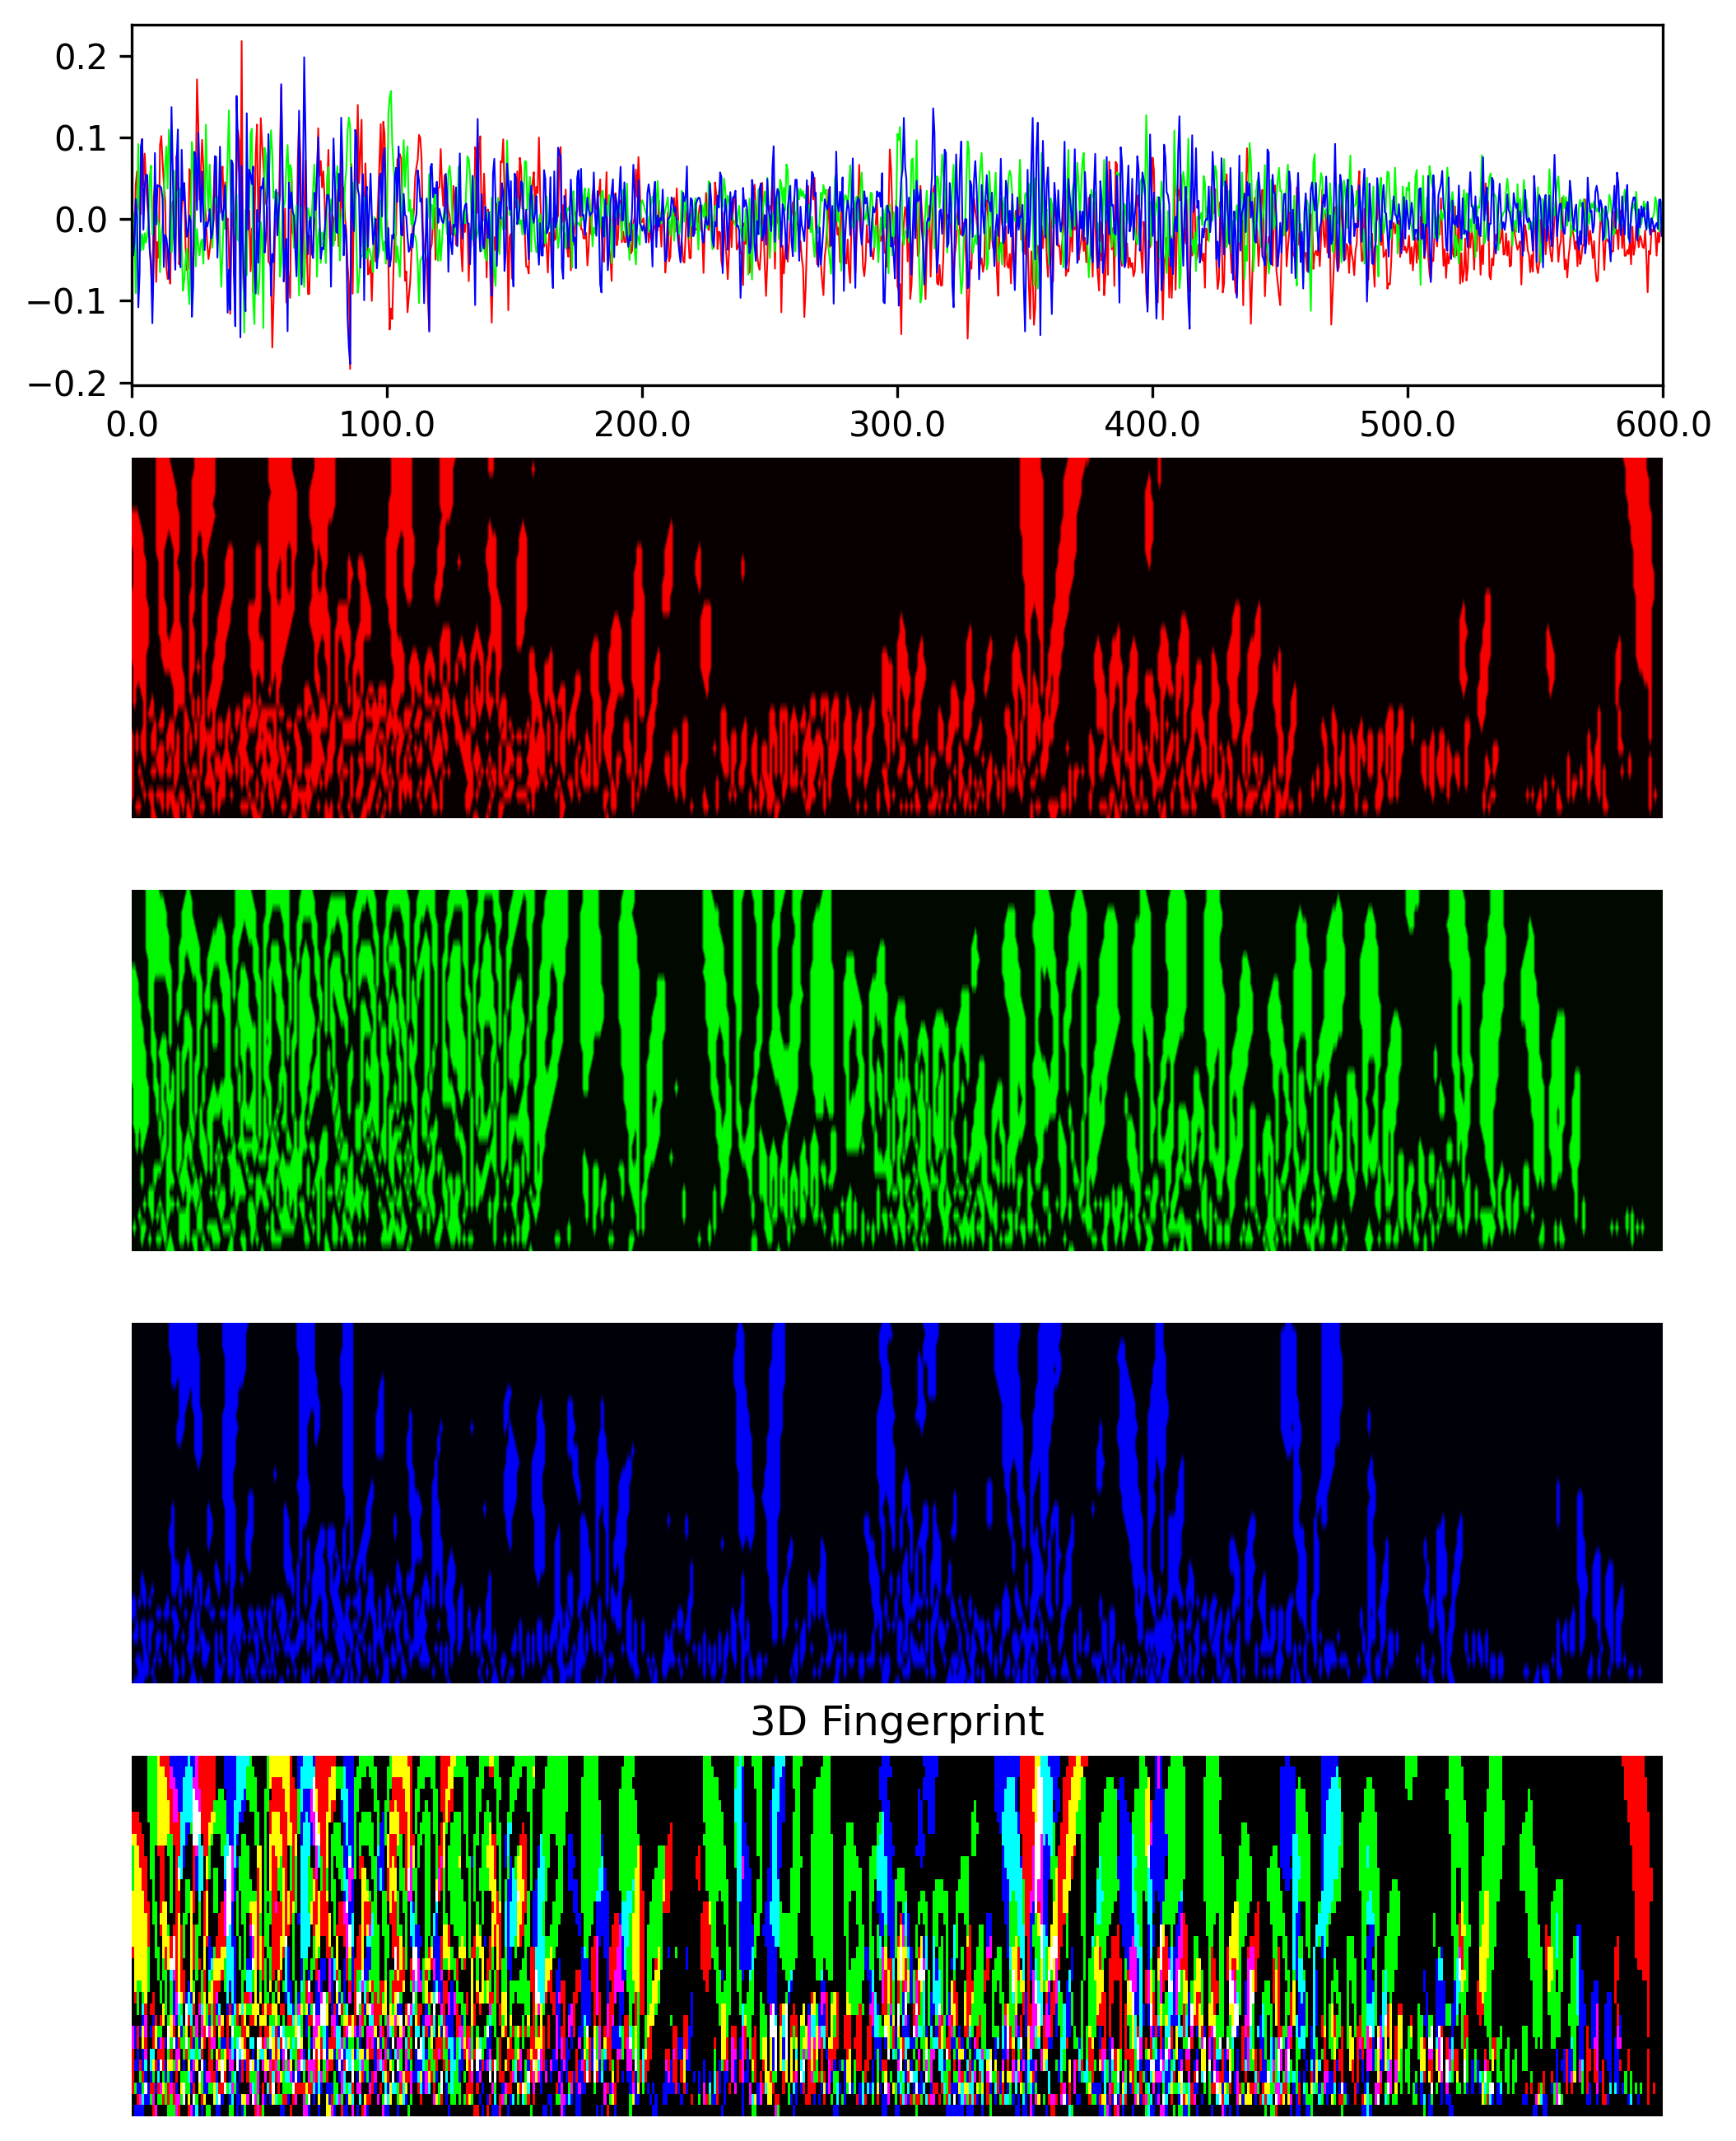

In [47]:
i=999
TDFPBuildChart(MoveDataSorted[i], MoveImgSorted[i], MoveTimeErrSorted[i], MovePredSorted[i], MoveFilesSorted[i][:6], MoveIndexesSorted[i])